<a href="https://colab.research.google.com/github/BarAvni/deep_learning_2020/blob/master/HW2_part_2_denoise_cats_Bar_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.patches as patches
from skimage.draw import random_shapes
import torch.optim as optim
import copy

In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')

model_save_name = 'denoise_cats_3_001.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

# Homework 2, part 2

1. below you will find a dataloader for the cats dataset (link to dataset file on the course website)

2. the function to add noise to the dataset is built into the dataloader

3. build a model that takes in the 256x256 image, and outputs an image of the same size 

4. use the nn.MSELoss() function

5. train the network

6. submit when you feel your network is doing a decent job at cleaning the images (remember to submit both model weights and source code)

In [0]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


class CustomDataset(Dataset):
    def __init__(self, path,start_idx, end_idx):
        
        self.data = np.load(path)
        self.data = self.data[start_idx:end_idx]

    def __len__(self):
       
        return len(self.data)
    
    def add_noise(self,y):
        newimg = random_shapes((256, 256),min_shapes=30,max_shapes=42,
                       multichannel=False, min_size=20,max_size=30,allow_overlap=True)[0]/255.0
        x = y.copy()
        x[np.where(newimg < 0.9)] = x[np.where(newimg < 0.9)]+1-newimg[newimg < 0.9]
        return x

    def __getitem__(self, idx):
        
        y = self.data[idx]

        x = torch.FloatTensor(self.add_noise(y)).unsqueeze(0)
        
        return x, torch.FloatTensor(y).unsqueeze(0)

## Load data

In [0]:
#!wget -O cats.npy https://www.dropbox.com/s/epykavp5x5e03e2/cats.npy?dl=0

In [0]:
train_ds = CustomDataset('cats.npy',0,800)
valid_ds = CustomDataset('cats.npy',800,1000)

In [0]:
x, y = train_ds[444]

In [7]:
y.shape

torch.Size([1, 256, 256])

In [8]:
x.shape

torch.Size([1, 256, 256])

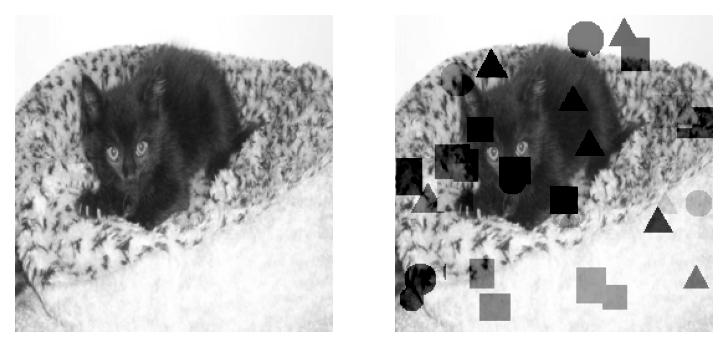

In [9]:
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].imshow(y[0],cmap='gist_yarg',vmin=0,vmax=1)
ax[1].imshow(x[0],cmap='gist_yarg',vmin=0,vmax=1)

for i in range(2):
    ax[i].set_axis_off()

plt.show()

In [0]:
conv_layer = nn.Conv2d(1,512,5,padding=2)

In [0]:
conv_layer = nn.Conv2d(1, 92, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))

In [12]:
batch_of_one = x.unsqueeze(0)

batch_of_one.shape

torch.Size([1, 1, 256, 256])

In [13]:
conv_layer(batch_of_one).shape

torch.Size([1, 92, 256, 256])

In [14]:
conv_layer2 = nn.Conv2d(92, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
y = conv_layer(batch_of_one)
y.shape

torch.Size([1, 92, 256, 256])

In [15]:
y = conv_layer2(y)
y.shape

torch.Size([1, 64, 256, 256])

In [16]:
conv_layer3 = nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
y = conv_layer3(y)
y.shape

torch.Size([1, 32, 256, 256])

In [0]:
# conv_layer4 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# y = conv_layer4(y)
# y.shape

In [0]:
# conv_layer5 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# y = conv_layer5(y)
# y.shape

In [0]:
# conv_layer6 = nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# y = conv_layer6(y)
# y.shape

In [0]:
class Denoise(nn.Module):

    def __init__(self):
        super(Denoise, self).__init__()
        # self.conv8 = nn.Conv2d(1, 92, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # self.dropout8 = nn.Dropout(0.2)
        # self.act8 = nn.ReLU(inplace=True)
        # self.bn8 = nn.BatchNorm2d(92)
        # self.conv1 = nn.Conv2d(92, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # self.dropout1 = nn.Dropout(0.2)
        self.act1 = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # self.dropout2 = nn.Dropout(0.2)
        self.act2 = nn.ReLU(inplace=True)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #self.dropout3 = nn.Dropout(0.3)
        self.act3 = nn.ReLU(inplace=True)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # self.dropout4 = nn.Dropout(0.2)
        self.act4 = nn.ReLU(inplace=True)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.act5 = nn.ReLU(inplace=True)
        self.bn5 = nn.BatchNorm2d(64)
        # self.conv6 = nn.Conv2d(64, 92, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # self.act6 = nn.ReLU(inplace=True)
        # self.bn6 = nn.BatchNorm2d(92)
        # self.conv7 = nn.Conv2d(92, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv6 = nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.act6 = nn.Sigmoid()

       
    def forward(self, x):
        # x = self.bn8(self.conv8(x))
        # x = self.bn1(self.dropout1(self.conv1(x)))
        # x = self.act8(x)
        x = self.bn1(self.conv1(x))
        # x = self.bn1(self.dropout1(self.conv1(x)))
        x = self.act1(x)
        x = self.bn2(self.conv2(x))
        # x = self.bn2(self.dropout2(self.conv2(x)))
        x = self.act2(x)
        x = self.bn3(self.conv3(x))
        # x = self.bn3(self.dropout3(self.conv3(x)))
        x = self.act3(x)
        x = self.bn4(self.conv4(x))
        # x = self.bn4(self.dropout4(self.conv4(x)))
        x = self.act4(x)
        x = self.bn5(self.conv5(x))
        # x = self.conv5(x)
        x = self.act5(x)
        # x = self.bn6(self.conv6(x))
        x = self.conv6(x)
        x = self.act6(x)
        # x = self.conv7(x)
        # x = self.act7(x)
        return x

## DataLoader, Run Training and Validation Step

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm


class Train:
    
    def __init__(self, architecture, dataset, params, path):
        
        self.cuda = params['cuda']
        if self.cuda:
            self.architecture = architecture.cuda()
        else:
            self.architecture = architecture
        self.dataset = dataset
        self.start_idx_train = params['start_idx_train']
        self.end_idx_train = params['end_idx_train']
        self.start_idx_val = params['start_idx_val']
        self.end_idx_val = params['end_idx_val']
        self.lr = params['lr']
        self.epochs = params['epochs']
        self.bs = params['bs']
        self.path_save = path
    
        

        self.train_dl, self.val_dl = self.__getdataset__()
        self.optimizer = self.__getoptimizer__()
        self.scheduler = self.__getscheduler__()
        self.loss_fn = self.__getlossfn__(params['lossfn'])

    
    def train(self):
        best_loss = 1000000
        best_model_wts = copy.deepcopy(self.architecture.state_dict())
        for _ in range(self.epochs):
            tr_loss = 0
            self.architecture.train()
            for _list in tqdm(self.train_dl):
                if self.cuda:
                    source = _list[0].cuda()
                    target = _list[-1].cuda()
                else:
                    source = _list[0]
                    target = _list[-1]
                _op = self.architecture(Variable(source))
                if len(_list) == 4:
                    if self.cuda:
                        mask = Variable(_list[1].cuda())
                    else:
                        mask = Variable(_list[1])
                    _loss = self.loss_fn(mask * _op, mask * Variable(target))
                else:
                    _loss = self.loss_fn(_op, Variable(target))
                tr_loss += _loss.data

                self.optimizer.zero_grad()
                _loss.backward()
                self.optimizer.step()
            
            val_loss = self.evaluate()
            #self.scheduler.step(val_loss)
                        # deep copy the model
            if tr_loss < best_loss:
                best_loss = tr_loss
                best_model_wts = copy.deepcopy(self.architecture.state_dict())
                torch.save(self.architecture.state_dict(), self.path_save)

            print(f'Training loss = {tr_loss}, Validation loss = {val_loss}')
        # load best model weights
        self.architecture.load_state_dict(best_model_wts)
        return self.architecture


    def evaluate(self):
        
        val_loss = 0
        self.architecture.eval()

        for _, _list in enumerate(self.val_dl):
            if self.cuda:
                source = _list[0].cuda()
                target = _list[-1].cuda()
            else:
                source = _list[0]
                target = _list[-1]
            _op = self.architecture(Variable(source))
            if len(_list) == 4:
                if self.cuda:
                    mask = Variable(_list[1].cuda())
                else:
                    mask = Variable(_list[1])
                _loss = self.loss_fn(mask * _op, mask * Variable(target))
            else:
                _loss = self.loss_fn(_op, Variable(target))
            val_loss += _loss.data
        
        return val_loss

    
    def __getdataset__(self):
        
        train_ds = CustomDataset(self.dataset ,self.start_idx_train, self.end_idx_train)
        train_dl = DataLoader(train_ds, batch_size=self.bs, shuffle=True)

        val_ds = CustomDataset(self.dataset, self.start_idx_val, self.end_idx_val)
        val_dl = DataLoader(val_ds, batch_size=self.bs)

        return train_dl, val_dl

    def __getoptimizer__(self):
        
        return optim.Adam(self.architecture.parameters(), self.lr)

    def __getscheduler__(self):
        
        return lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=self.epochs/4, factor=0.5, verbose=True)

    def __getlossfn__(self, lossfn):
        
        if lossfn == 'l2':
            return nn.MSELoss()
        elif lossfn == 'l1':
            return nn.L1Loss()
        else:
            raise ValueError('No such loss function supported')


In [22]:
architecture = Denoise()
params = {
    'start_idx_train' : 200,
    'end_idx_train' : 1000,
    'start_idx_val' : 0,
    'end_idx_val' : 200,
    'lr': 0.001,
    'epochs': 50,
    'bs': 25,
    'lossfn': 'l2',
    'cuda': True
}
trainer = Train(architecture, 'cats.npy', params, path)
trainer.train()

  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.6186805963516235, Validation loss = 0.19868943095207214


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.4058489203453064, Validation loss = 0.10476340353488922


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.343680202960968, Validation loss = 0.08833007514476776


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.3037482798099518, Validation loss = 0.07860668748617172


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.2710629403591156, Validation loss = 0.11126257479190826


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.2726207673549652, Validation loss = 0.10496024042367935


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.24480755627155304, Validation loss = 0.06461739540100098


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.27295559644699097, Validation loss = 0.0851631686091423


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.2355535477399826, Validation loss = 0.06637272238731384


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.23097534477710724, Validation loss = 0.13799121975898743


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.23951633274555206, Validation loss = 0.06782282888889313


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.22655141353607178, Validation loss = 0.051338087767362595


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.2342189997434616, Validation loss = 0.05943552032113075


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.21983098983764648, Validation loss = 0.050917964428663254


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.22643950581550598, Validation loss = 0.04842788353562355


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.21488793194293976, Validation loss = 0.054370369762182236


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.20832988619804382, Validation loss = 0.04990263283252716


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.18522533774375916, Validation loss = 0.04847245663404465


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.20932872593402863, Validation loss = 0.07427027821540833


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.208913654088974, Validation loss = 0.044809043407440186


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.19759196043014526, Validation loss = 0.05903778225183487


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.21157892048358917, Validation loss = 0.055674437433481216


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.20487692952156067, Validation loss = 0.05703701078891754


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.18706996738910675, Validation loss = 0.05277247726917267


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.1946316510438919, Validation loss = 0.04546058550477028


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.1935461312532425, Validation loss = 0.044999875128269196


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.18696574866771698, Validation loss = 0.044377490878105164


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.20196373760700226, Validation loss = 0.051615841686725616


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.19631269574165344, Validation loss = 0.046858981251716614


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.18978238105773926, Validation loss = 0.050539109855890274


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.19749800860881805, Validation loss = 0.053502485156059265


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.1795019954442978, Validation loss = 0.0451636016368866


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.17672237753868103, Validation loss = 0.04515042155981064


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.17534026503562927, Validation loss = 0.03944907709956169


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.1722237467765808, Validation loss = 0.0401032418012619


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.17814847826957703, Validation loss = 0.08103932440280914


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.17373166978359222, Validation loss = 0.039613038301467896


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.17264316976070404, Validation loss = 0.08841874450445175


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.16741587221622467, Validation loss = 0.047158002853393555


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.16758117079734802, Validation loss = 0.08136780560016632


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.1720794141292572, Validation loss = 0.04222200810909271


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.18557609617710114, Validation loss = 0.04121105372905731


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.17451919615268707, Validation loss = 0.053264718502759933


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.17072594165802002, Validation loss = 0.13154028356075287


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.1796036958694458, Validation loss = 0.04255600646138191


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.1660144329071045, Validation loss = 0.03958152234554291


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.16356545686721802, Validation loss = 0.06182299554347992


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.16379858553409576, Validation loss = 0.09274443984031677


  0%|          | 0/32 [00:00<?, ?it/s]

Training loss = 0.16518495976924896, Validation loss = 0.04329211264848709


100%|██████████| 32/32 [00:20<00:00,  1.52it/s]


Training loss = 0.14446797966957092, Validation loss = 0.05892988294363022


Denoise(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU(inplace=True)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU(inplace=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU(inplace=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU(inplace=True)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU(inplace=True)
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d

In [23]:
m = trainer.architecture
m.load_state_dict(torch.load(path))

<All keys matched successfully>

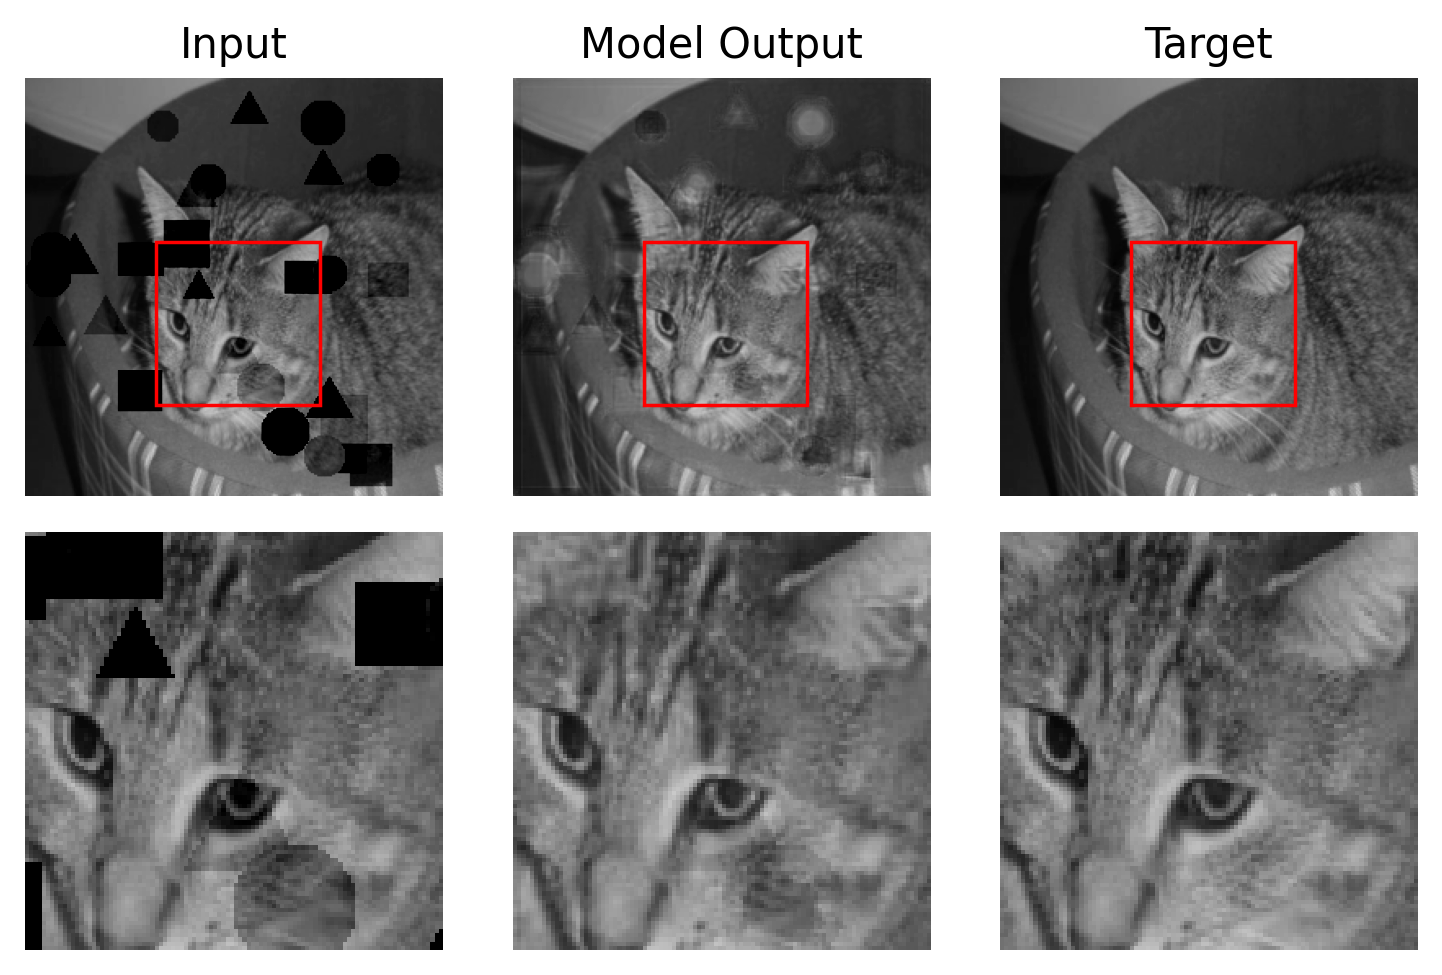

In [24]:
x, y = valid_ds[120]

fig,ax = plt.subplots(2,3,figsize=(6,(6/3)*2),dpi=250)

m.cpu()
m.eval()

input_img = x[0]
model_pred = m(x.unsqueeze(0))[0].cpu().data.numpy()[0]

ground_truth = y[0]

patch_xy = [80,100]
patch_hw = [100,100]


ax[0][0].set_title('Input',fontsize=12)
ax[0][1].set_title('Model Output',fontsize=12)
ax[0][2].set_title('Target',fontsize=12)

ax[0][0].imshow(input_img,cmap='gist_yarg',vmin=0,vmax=1)
ax[0][1].imshow(model_pred,cmap='gist_yarg',vmin=0,vmax=1)
ax[0][2].imshow(ground_truth,cmap='gist_yarg',vmin=0,vmax=1)


for i in range(0,3):
    rect = patches.Rectangle(patch_xy,patch_hw[0],patch_hw[1],linewidth=1,edgecolor='r',facecolor='none')
    ax[0][i].add_patch(rect)


input_img    = input_img[patch_xy[1]:patch_xy[1]+patch_hw[1],patch_xy[0]:patch_xy[0]+patch_hw[0]] 
model_pred   = model_pred[patch_xy[1]:patch_xy[1]+patch_hw[1],patch_xy[0]:patch_xy[0]+patch_hw[0]]    
ground_truth = ground_truth[patch_xy[1]:patch_xy[1]+patch_hw[1],patch_xy[0]:patch_xy[0]+patch_hw[0]] 


ax[1][0].imshow(input_img,cmap='gist_yarg',vmin=0,vmax=1)
ax[1][1].imshow(model_pred,cmap='gist_yarg',vmin=0,vmax=1)
ax[1][2].imshow(ground_truth,cmap='gist_yarg',vmin=0,vmax=1)


for i in range(3):
    for j in range(2):
        ax[j][i].set_axis_off()

plt.tight_layout()
plt.show()